##  EE444/588 Project 4
Abu Bucker Siddik

In [127]:
import matplotlib.pyplot as plt
import scipy.io as spio
import skimage.measure
from sklearn import svm
import sklearn.metrics
import numpy as np
import imageio.v2 as imageio
import os
import glob
import time
from sklearn.preprocessing import normalize
%matplotlib inline 
plt.rcParams.update({'font.size': 12})

## (a) CalTech101 Dataset setup
In this project, we use the CalTech101 dataset, which is a standard dataset used for image classification. We download the <b>caltech-101.zip</b> file where images extract to <b>101_ObjectCategories/</b> directory and the annotations extract to <b>Annotations/</b> directory.

## (a-i) Display example CalTech101 images:
We store the directory names of <b>101_ObjectCategories/</b> directory in a list <b>categories</b> and loop over the 101 different categories of objects in that list. We read in the first image <b>(image_0001.jpg)</b> from each of the 101 categories and display that image in one location of an 11×10 subplot.


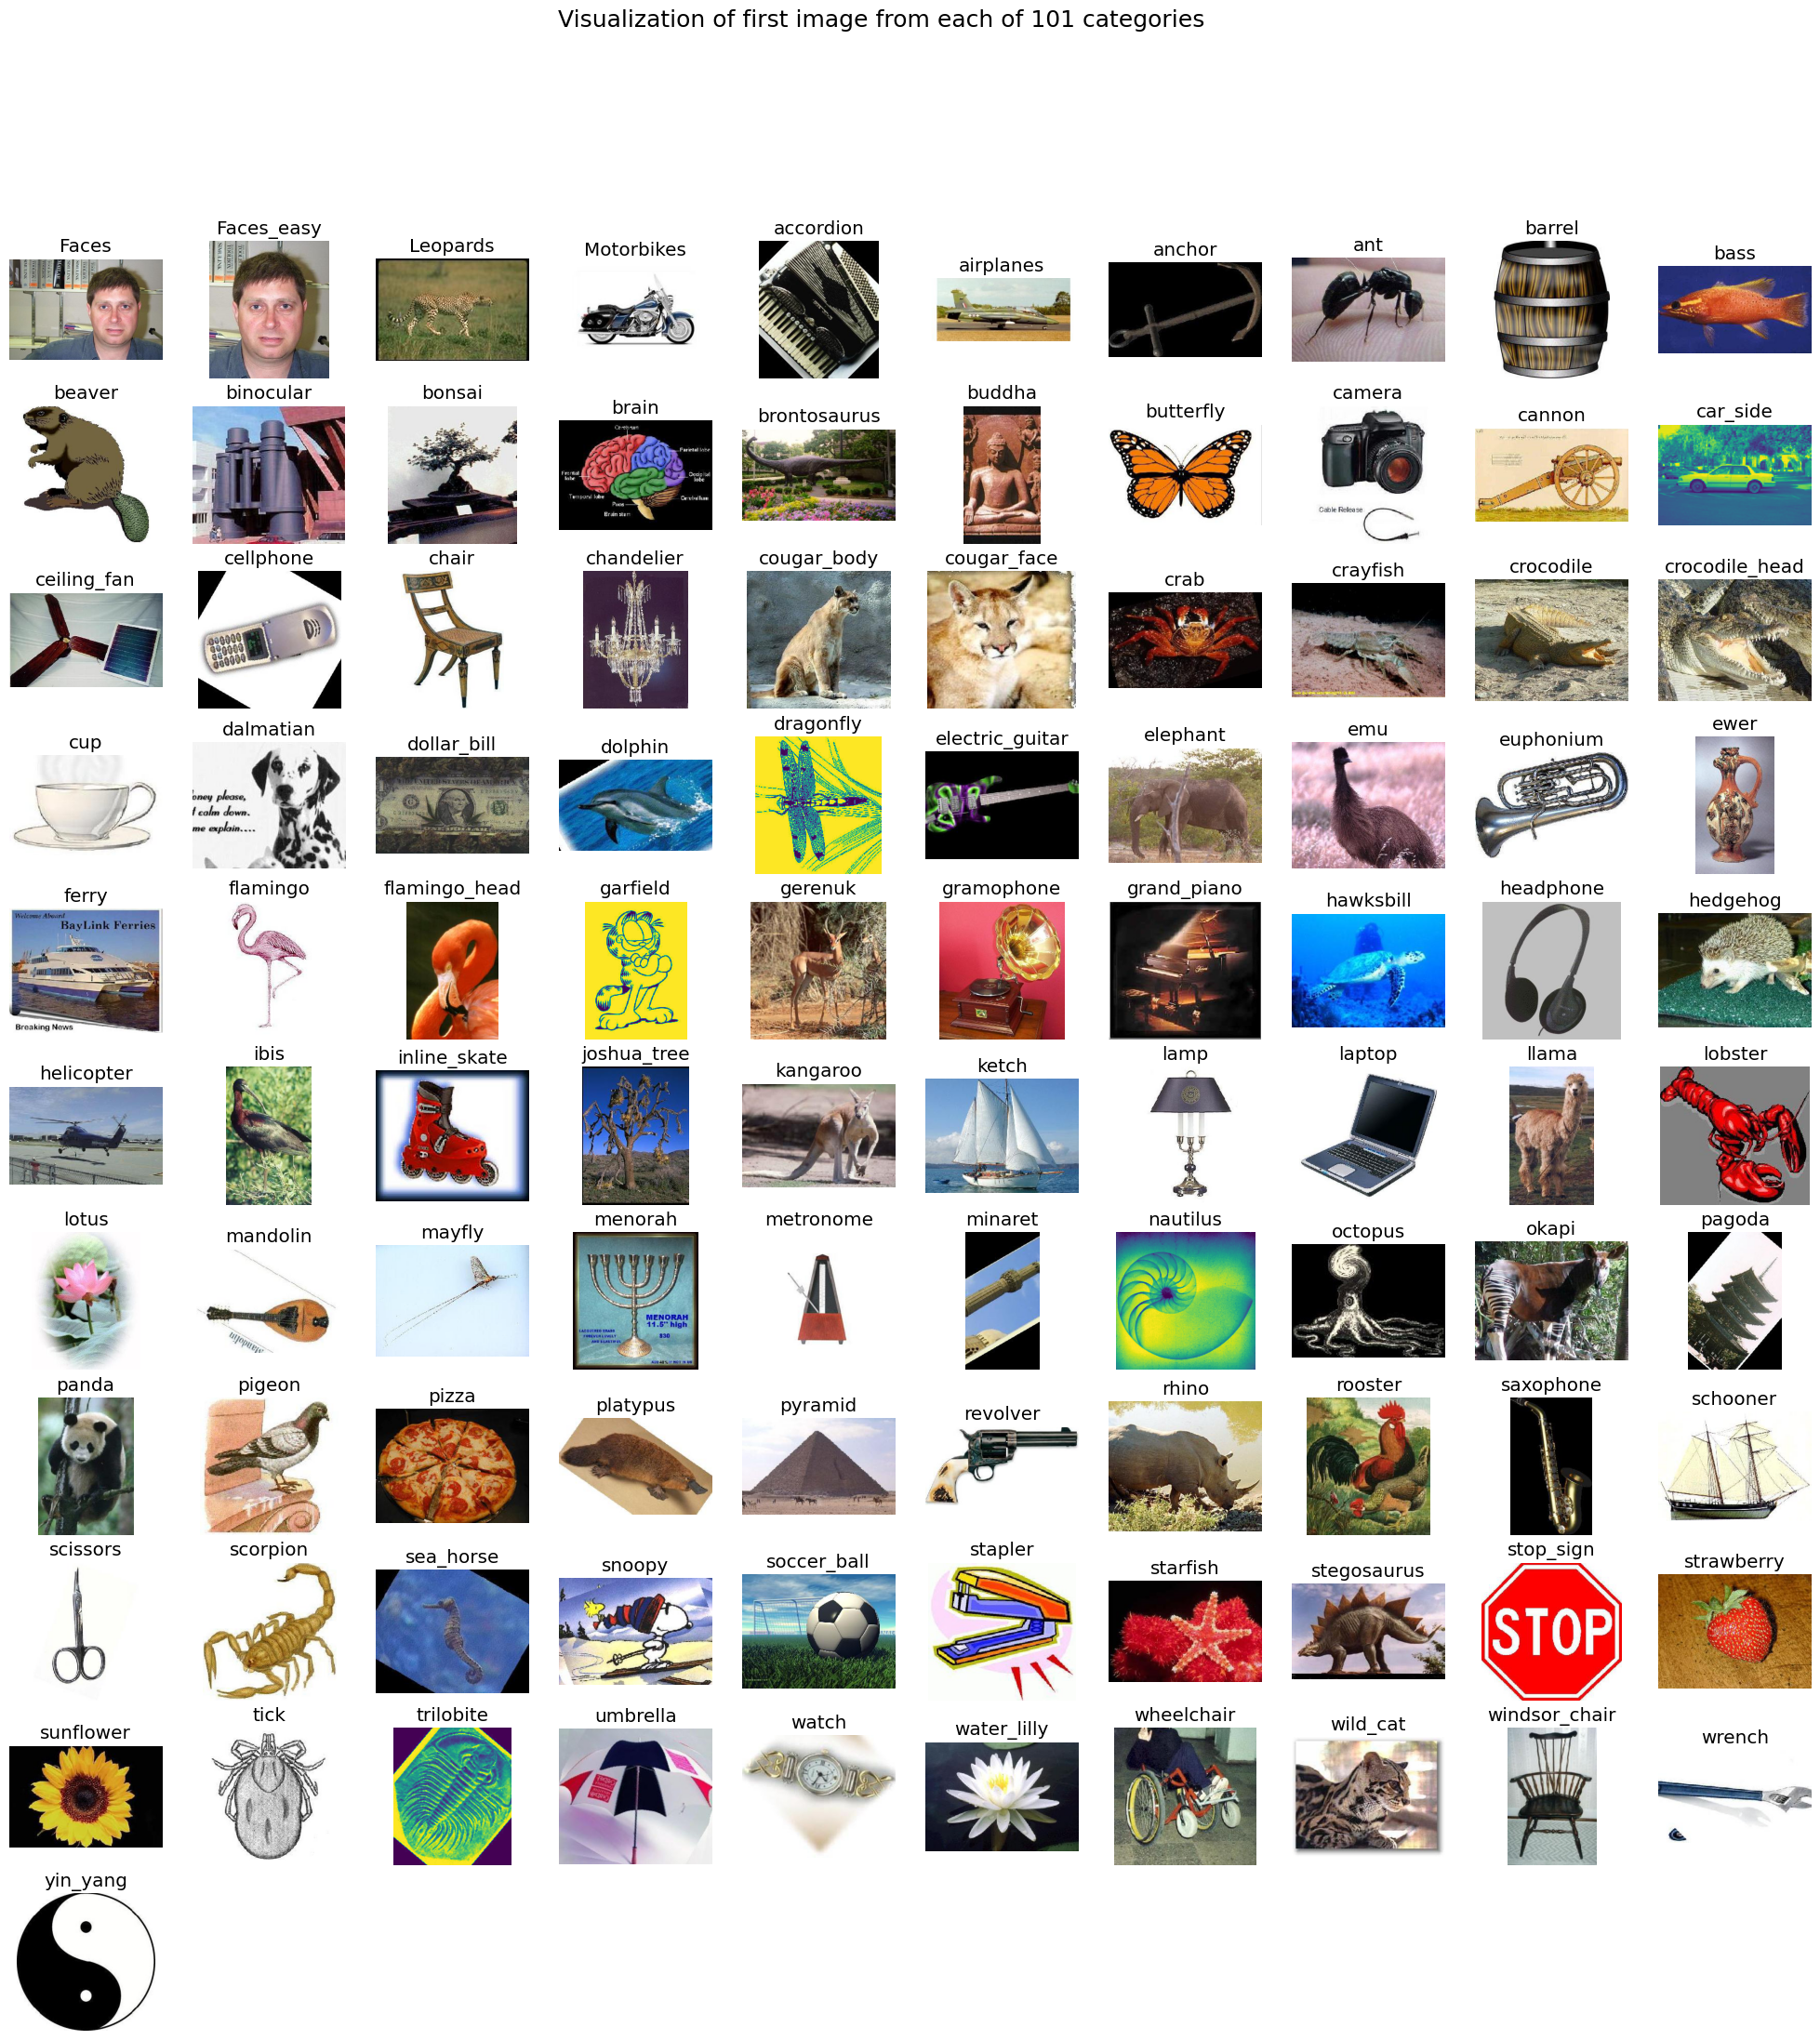

In [128]:
categories=sorted(glob.glob('101_ObjectCategories/*'))
plt.figure(figsize=(25, 25)) 
for k,image_filename in enumerate(categories):
    I = imageio.imread(categories[k]+'/image_0001.jpg')
    plt.subplot(11, 10, k+1)
    plt.imshow(I)
    plt.axis('off')
    plt.title(categories[k][21:])
plt.suptitle('Visualization of first image from each of 101 categories', fontsize = 18)
plt.show()
    

We observe that CalTech101 dataset contains different types of objects which makes it useful for analyzing performance of image classification methods.

## (a-ii) Reading and visualizing annotations:
We read in <b>Annotations/emu/annotation_0001.mat</b> and display <b>box_coord</b> and <b>obj_contour</b>.
We read in image <b>101_ObjectCategories/emu/image_0001.jpg</b> and display the image. We also plot the annotation outline on top of that image.

In [129]:
ann=spio.loadmat('Annotations/emu/annotation_0001.mat')

In [130]:
print('box_coord: ', ann['box_coord'])

box_coord:  [[  7 247  72 293]]


In [131]:
print('obj_contour: ', ann['obj_contour'])

obj_contour:  [[ 16.57982456  14.46578947  11.50614035   9.39210526  18.27105263
   29.26403509  36.8745614   39.83421053  47.86754386  36.45175439
   31.37807018  43.21666667  77.46403509 104.52368421 127.77807018
  159.06578947 189.93070175 204.30614035 215.29912281 213.60789474
  163.29385965 141.30789474 123.12719298  92.68508772  74.92719298
   50.82719298  19.11666667   6.85526316   6.00964912  17.4254386
   17.4254386 ]
 [ 78.93070175  53.98508772  28.19385965  10.43596491   2.8254386
    5.3622807   13.81842105  25.23421053  34.95877193  35.38157895
   42.99210526  81.04473684 119.94298246 117.82894737 123.3254386
  141.08333333 168.98859649 196.47105263 229.87280702 240.02017544
  240.44298246 217.18859649 240.44298246 240.02017544 232.83245614
  223.10789474 193.51140351 163.49210526 113.60087719  78.50789474
   78.50789474]]


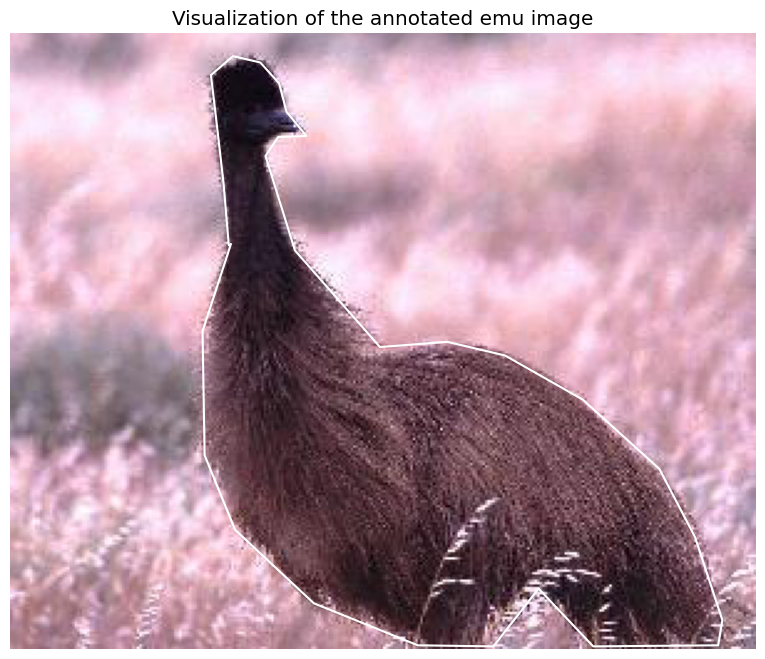

In [132]:
# Reading image
I = imageio.imread('101_ObjectCategories/emu/image_0001.jpg')

plt.figure(figsize=(10, 8)) 
plt.imshow(I)
plt.plot(ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,'w')
plt.axis('off')
plt.title('Visualization of the annotated emu image')
plt.show()

## (a-iii) Generating an object mask:
We use the object contour outline to define a binary image image mask. We load the first annotation <b>(annotation_0001.mat)</b> from each of the 101 categories, use the corresponding <b>obj_contour</b> to define an object mask, and display that mask in one location of an 11×10 subplot. 

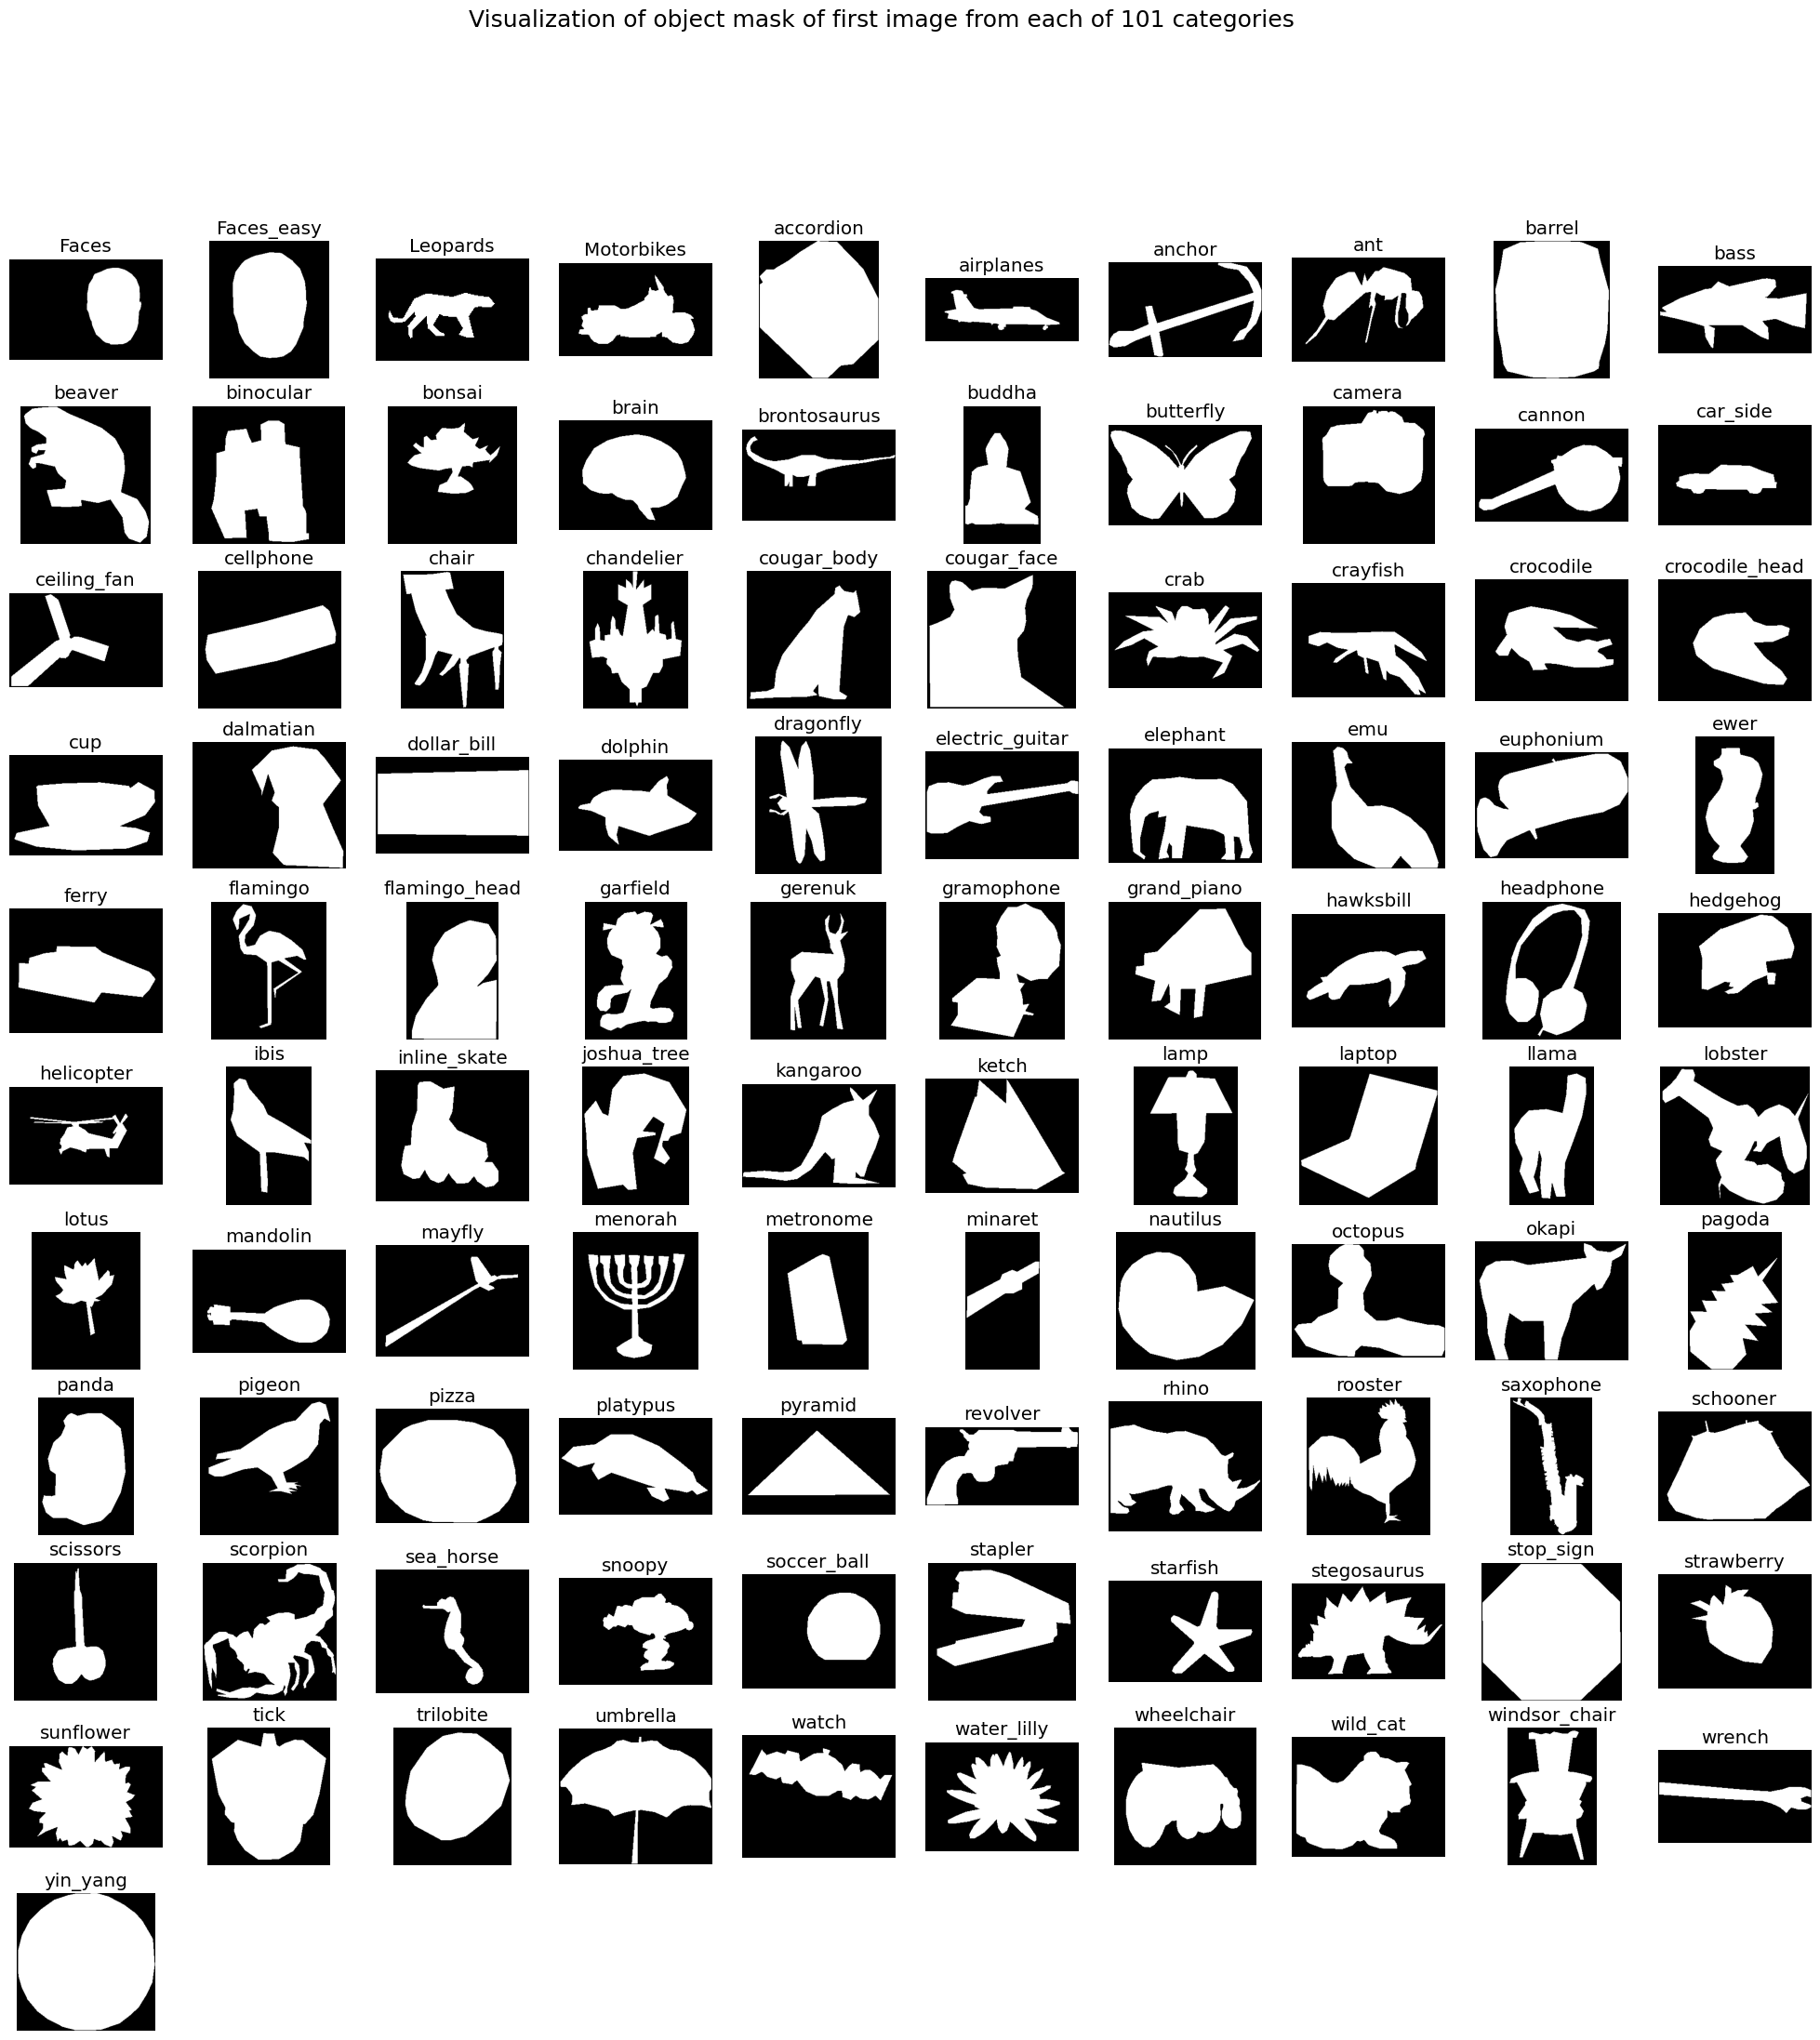

In [133]:
Annot=sorted(glob.glob('Annotations/*'))

plt.figure(figsize=(25, 25)) 
for k,image_filename in enumerate(categories):
    I = imageio.imread(categories[k]+'/image_0001.jpg')
    M=I.shape[0]
    N=I.shape[1]
    ann=spio.loadmat(Annot[k]+'/annotation_0001.mat')
    r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,ann['obj_contour'][0,:]+\
                           ann['box_coord'][0,2]-1,(M,N));
    A=np.zeros((M,N))
    A[r,c]=1
    A1 = np.array(A,dtype='bool')
    A2=skimage.morphology.remove_small_objects(A1,2)
    A3=skimage.morphology.remove_small_holes(A2)
    A3=A3.astype(int)
    A3[0,:]=0
    A3[M-1,:]=0
    A3[:,0]=0
    A3[:,N-1]=0
    
    plt.subplot(11, 10, k+1)
    plt.imshow(A3, cmap='gray')
    plt.axis('off')
    plt.title(categories[k][21:])
plt.suptitle('Visualization of object mask of first image from each of 101 categories', fontsize = 18)
plt.show()   

## (b) Extracting Color Features
In this part, we write code to extract color features from an image. 

## (b-i) Color feature function:
We create a function <b>f,fnames=extract_color_features(im,mask)</b> with inputs <b>im</b>, the image from which to extract features, and the binary annotation mask <b>mask</b>. Outputs of the function <b>extract_color_features</b> are a length-30 feature vector <b>f</b> describing statistics of the colors within the image object and a length-30 list <b>fnames</b> with the feature names. If the image is
natively grayscale, the function first converts the image to RGB. Then from each channel of RGB, it computes the mean, standard deviation, median, min, and max value of pixels within the object mask. The function also extract the same statistics as RGB for each channels of HSV.

In [16]:
def extract_color_features(im,mask):
    im_1=im
    if (len(im.shape)<3):
        im_1=skimage.color.gray2rgb(im)
    R=im_1[:,:,0]
    G=im_1[:,:,1]
    B=im_1[:,:,2]
    
    # features for R channel
    R_mean=np.mean(R[mask == 1])
    R_std=np.std(R[mask == 1])
    R_median=np.median(R[mask == 1])
    R_min=np.min(R[mask == 1])
    R_max=np.max(R[mask == 1])
    
    # features for G channel
    G_mean=np.mean(G[mask == 1])
    G_std=np.std(G[mask == 1])
    G_median=np.median(G[mask == 1])
    G_min=np.min(G[mask == 1])
    G_max=np.max(G[mask == 1])
    
    # features for B channel
    B_mean=np.mean(B[mask == 1])
    B_std=np.std(B[mask == 1])
    B_median=np.median(B[mask == 1])
    B_min=np.min(B[mask == 1])
    B_max=np.max(B[mask == 1])
    
    # converting RGB to hsv
    im_hsv=skimage.color.rgb2hsv(im_1)
    
    H=im_hsv[:,:,0]
    S=im_hsv[:,:,1]
    V=im_hsv[:,:,2]
    
    # features for H channel
    H_mean=np.mean(H[mask == 1])
    H_std=np.std(H[mask == 1])
    H_median=np.median(H[mask == 1])
    H_min=np.min(H[mask == 1])
    H_max=np.max(H[mask == 1])
    
    # features for S channel
    S_mean=np.mean(S[mask == 1])
    S_std=np.std(S[mask == 1])
    S_median=np.median(S[mask == 1])
    S_min=np.min(S[mask == 1])
    S_max=np.max(S[mask == 1])
    
    # features for V channel
    V_mean=np.mean(V[mask == 1])
    V_std=np.std(V[mask == 1])
    V_median=np.median(V[mask == 1])
    V_min=np.min(V[mask == 1])
    V_max=np.max(V[mask == 1])
    
    f=[R_mean, R_std, R_median, R_min, R_max, G_mean, G_std, G_median, G_min, G_max, \
      B_mean, B_std, B_median, B_min, B_max, H_mean, H_std, H_median, H_min, H_max, \
      S_mean, S_std, S_median, S_min, S_max, V_mean, V_std, V_median, V_min, V_max]
    
    fnames=['R_mean', 'R_std', 'R_median', 'R_min', 'R_max', \
            'G_mean', 'G_std', 'G_median', 'G_min', 'G_max', \
            'B_mean', 'B_std', 'B_median', 'B_min', 'B_max', \
            'H_mean', 'H_std', 'H_median', 'H_min', 'H_max', \
            'S_mean', 'S_std', 'S_median', 'S_min', 'S_max', \
            'V_mean', 'V_std', 'V_median', 'V_min', 'V_max']
    return f, fnames
    

## (b-ii) Example color features:
Using <b>101_ObjectCategories/emu/image_0001.jpg</b> as the input image <b>im</b> and <b>Annotations/emu/annotation_0001.mat</b> as the annotation mask <b>mask</b>, we use <b>extract_color_features</b> function and print out <b>f</b> vector and <b>fnames</b> list.

In [17]:
I = imageio.imread('101_ObjectCategories/emu/image_0001.jpg')
M=I.shape[0]
N=I.shape[1]
ann=spio.loadmat('Annotations/emu/annotation_0001.mat')
r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,ann['obj_contour'][0,:]+\
                           ann['box_coord'][0,2]-1,(M,N));
A=np.zeros((M,N))
A[r,c]=1
A1 = np.array(A,dtype='bool')
A2=skimage.morphology.remove_small_objects(A1,2)
A3=skimage.morphology.remove_small_holes(A2)
A3=A3.astype(int)
A3[0,:]=0
A3[M-1,:]=0
A3[:,0]=0
A3[:,N-1]=0


In [18]:
f,fnames=extract_color_features(I,A3)
print('f vector: ', f)

f vector:  [89.66263904034896, 41.77544730860127, 85.0, 3, 255, 60.43520174482006, 36.479201879692546, 53.0, 0, 250, 70.16239912758996, 37.50792712320316, 63.0, 0, 255, 0.9319160505364285, 0.07237925220295986, 0.9473684210526316, 0.0, 0.9966666666666667, 0.3612537870160193, 0.11130164163464257, 0.34951456310679613, 0.019607843137254943, 1.0, 0.35243261273975235, 0.16304442276782372, 0.3333333333333333, 0.0196078431372549, 1.0]


In [19]:
print('fnames list: ', fnames)

fnames list:  ['R_mean', 'R_std', 'R_median', 'R_min', 'R_max', 'G_mean', 'G_std', 'G_median', 'G_min', 'G_max', 'B_mean', 'B_std', 'B_median', 'B_min', 'B_max', 'H_mean', 'H_std', 'H_median', 'H_min', 'H_max', 'S_mean', 'S_std', 'S_median', 'S_min', 'S_max', 'V_mean', 'V_std', 'V_median', 'V_min', 'V_max']


## (c) Extracting Boundary Features
In this part, we write code to extract boundary features from an image.

## (c-i) Boundary feature function:
We create a function <b>f,fnames=extract_boundary_features(mask)</b> with input <b>mask</b>, the binary annotation mask. Outputs of <b>extract_boundary_features</b> are a length-10 feature vector <b>f</b> consisting of the length-10 Fourier descriptors for the object in <b>mask</b> and a length-10 list <b>fnames</b> with feature names.

In [20]:
def extract_boundary_features(mask):
    B=skimage.measure.find_contours(mask,0.5)
    B1=B[0]
    B2=B1[:-1]
    s_k=[]
    for i in range (len(B2)):
        B3=B2[i]
        B4=complex(B3[0],B3[1])
        s_k.append(B4)
    s_k1= np.array(s_k) 
    S=np.fft.fft(s_k1, n=10000)
    f=np.zeros((10))
    for k in range(0,10):
        f[k] = np.abs(S[k*1000:(k+1)*1000].sum())
    
    fnames=['Fourier_desc_a0', 'Fourier_desc_a1', 'Fourier_desc_a2', 'Fourier_desc_a3', \
            'Fourier_desc_a4', 'Fourier_desc_a5', 'Fourier_desc_a6', 'Fourier_desc_a7', \
            'Fourier_desc_a8', 'Fourier_desc_a9']
    
    return f, fnames
        
    
    

## (c-ii) Example boundary features:
Using <b>101_ObjectCategories/emu/image_0001.jpg</b> as in the input image <b>im</b> and <b>Annotations/emu/annotation_0001.mat</b> as the annotation mask <b>mask</b>, we use <b>extract_boundary_features</b> function and print out <b>f</b> vector and <b>fnames</b> list.

In [21]:
f, fnames= extract_boundary_features(A3)

In [23]:
print('Length-10 Fourier descriptor vector: ', f)

Length-10 Fourier descriptor vector:  [3637364.51489201  428533.91905037  268666.33382016  211784.36752886
  190387.59983921  190366.9532755   211709.16826401  269000.4876408
  430190.94765179 3695814.06216116]


In [24]:
print('Feature names: ', fnames)

Feature names:  ['Fourier_desc_a0', 'Fourier_desc_a1', 'Fourier_desc_a2', 'Fourier_desc_a3', 'Fourier_desc_a4', 'Fourier_desc_a5', 'Fourier_desc_a6', 'Fourier_desc_a7', 'Fourier_desc_a8', 'Fourier_desc_a9']


## (d) Extracting Region features:
In this part, we write code to extract region features from an image.

## (d-i) Hu moments function:
We create a function <b>f,f_names=extract_hu_moments(mask)</b> with input <b>mask</b>, the binary annotation mask. Outputs of  function <b>extract_hu_moments</b> are a length-7 feature vector <b>f</b> consisting of the 7 moment invariants (Hu moments—equations (12-39) through (12-45) for the object in <b>mask</b>) and a
length-7 list <b>f_names</b> with feature names.

In [25]:
def moment(mask, p, q):
    x1=[]
    y1=[]
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            x1.append(i)
            y1.append(j)
    x=np.array(x1)  
    y=np.array(y1) 
    f_x_y=mask.flatten()
    m_pq=(np.power(x, p))*(np.power(y, q))*f_x_y
    m_pq_s=m_pq.sum()
    
    return m_pq_s  

In [26]:
def normalized_central_moment(mask, p, q, x_bar, y_bar):
    x1=[]
    y1=[]
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            x1.append(i)
            y1.append(j)
    x=np.array(x1)  
    y=np.array(y1) 
    f_x_y=mask.flatten()
    x_s=x-x_bar
    y_s=y-y_bar
    mu_pq=(np.power(x_s, p))*(np.power(y_s, q))*f_x_y
    mu_pq_s=mu_pq.sum()
    return mu_pq_s
    
    

In [27]:
def extract_hu_moments(mask):
    m_10=moment(mask, 1, 0)
    m_00=moment(mask, 0, 0)
    m_01=moment(mask, 0, 1)
    x_bar=m_10/m_00
    y_bar=m_01/m_00
    mu_00=normalized_central_moment(mask, 0, 0, x_bar, y_bar)
    eta_20=normalized_central_moment(mask, 2, 0, x_bar, y_bar)/(np.power(mu_00, 2))
    eta_02=normalized_central_moment(mask, 0, 2, x_bar, y_bar)/(np.power(mu_00, 2))
    eta_11=normalized_central_moment(mask, 1, 1, x_bar, y_bar)/(np.power(mu_00, 2))
    eta_12=normalized_central_moment(mask, 1, 2, x_bar, y_bar)/(np.power(mu_00, 2.5))
    eta_21=normalized_central_moment(mask, 2, 1, x_bar, y_bar)/(np.power(mu_00, 2.5))
    eta_30=normalized_central_moment(mask, 3, 0, x_bar, y_bar)/(np.power(mu_00, 2.5))
    eta_03=normalized_central_moment(mask, 0, 3, x_bar, y_bar)/(np.power(mu_00, 2.5))
    phi1=eta_20+eta_02
    phi2=((eta_20-eta_02)**2)+(4*(eta_11**2))
    phi3=((eta_30-3*eta_12)**2)+((3*eta_21-eta_03)**2)
    phi4=((eta_30+eta_12)**2)+((eta_21+eta_03)**2)
    phi5=(eta_30-3*eta_12)*(eta_30+eta_12)*((eta_30+eta_12)**2 - (3*(eta_21+eta_03)**2))\
         + (3*eta_21-eta_03)*(eta_21 + eta_03) * (3* (eta_30 + eta_12) ** 2 - (eta_21 + eta_03)**2)
    phi6 = (eta_20-eta_02) * ((eta_30+eta_12) ** 2 - (eta_21+eta_03) ** 2)\
          + 4*eta_11*(eta_30+eta_12)*(eta_21+eta_03)
    phi7 = (3*eta_21-eta_03) * (eta_30+eta_12)*((eta_30 + eta_12)**2 - 3*(eta_21 + eta_03)**2)\
           +(3*eta_12-eta_30)*(eta_21+eta_03)*(3*(eta_30+eta_12)** 2-(eta_21+eta_03)**2)
    
    f=[phi1, phi2, phi3, phi4, phi5, phi6, phi7]
    f_names=['phi1', 'phi2', 'phi3', 'phi4', 'phi5', 'phi6', 'phi7']
    return f, f_names
    

## (d-ii) Example Hu moments: 
Using <b>101_ObjectCategories/emu/image_0001.jpg</b> as in the input image <b>im</b> and <b>Annotations/emu/annotation_0001.mat</b> as the annotation mask <b>mask</b>, we use <b>extract_hu_moments</b> function and print out <b>f</b> vector and <b>f_names</b> list.

In [28]:
f,f_names=extract_hu_moments(A3)

In [29]:
print('Hue moment feature values: ', f)

Hue moment feature values:  [0.2510941623851788, 0.022047385733876795, 0.006437407831751308, 0.0012677765412814875, 2.5454808522395282e-06, 1.2565845541501967e-05, 2.576367086492271e-06]


In [30]:
print('Hue moment feature names: ', f_names)

Hue moment feature names:  ['phi1', 'phi2', 'phi3', 'phi4', 'phi5', 'phi6', 'phi7']


## (d-iii) Region feature extraction:
We create a function <b>Region_feature_extraction(mask)</b> to extract important 11 region features.

In [31]:
def Region_feature_extraction(mask):
    props=skimage.measure.regionprops(mask)
    area=props[0].area
    convex_area=props[0].area_convex
    eccentricity=props[0].eccentricity
    equivalent_diameter=props[0].equivalent_diameter_area
    euler_number=props[0].euler_number
    extent=props[0].extent
    filled_area=props[0].area_filled
    major_axis_length=props[0].axis_major_length
    minor_axis_length=props[0].axis_minor_length
    perimeter=props[0].perimeter
    solidity=props[0].solidity
    
    f=[area, convex_area, eccentricity, equivalent_diameter, euler_number, extent, filled_area, \
       major_axis_length, minor_axis_length, perimeter, solidity]
    
    f_names=['area', 'convex_area', 'eccentricity', 'equivalent_diameter', \
             'euler_number', 'extent', 'filled_area',  'major_axis_length', \
             'minor_axis_length', 'perimeter', 'solidity']
    return f, f_names
    

## (d-iv) Example region features:
Using <b>101_ObjectCategories/emu/image_0001.jpg</b> as in the input image <b>im</b> and <b>Annotations/emu/annotation_0001.mat</b> as the annotation mask <b>mask</b>,
we print out <b>f</b> vector and <b>f_names</b> list.

In [32]:
f, f_names=Region_feature_extraction(A3)

print('Region Features: ', f)


Region Features:  [22925, 28790, 0.86209198262317, 170.8479340321492, 1, 0.46087813115676896, 22925, 270.70752758375147, 137.18153400649817, 824.5655839020935, 0.7962834317471345]


In [33]:
print('Region Feature names: ', f_names)

Region Feature names:  ['area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number', 'extent', 'filled_area', 'major_axis_length', 'minor_axis_length', 'perimeter', 'solidity']


## (e) Extracting Texture Features:
In this part, we write code to extract texture features from an image.

## (e-i) Texture features function:
We create a function <b>f,f_names=extract_texture_features(im,mask)</b> with inputs <b>im</b>, the image from which to extract features, and the binary annotation mask <b>mask</b>. Outputs of function <b>extract_texture_features</b> are a length-32 feature vector <b>f</b> describing co-occurrence matrix features within the image object and a length-32 list <b>f_names</b> with the feature names.

In [34]:
def extract_texture_features(im,mask):
    im_1=im
    shape_im=len(im.shape)
    if (shape_im<3):
        im_1=skimage.color.gray2rgb(im)
    I2=skimage.color.rgb2gray(im_1)
    I_q=np.round(I2*31).astype(int)
    I_q[mask==0]=32
    GLCM=skimage.feature.graycomatrix(I_q,distances=(1,2,3,4),angles=(0,np.pi/4,np.pi/2,\
     3*np.pi/4),levels=33,symmetric=True,normed=False)
    
    G11=GLCM[:-1,:,:,:]
    G22=G11[:,:-1,:,:]
    G=np.zeros((G22.shape))
    for d in range(0,4):
        for t in range(0,4):
            G[:,:,d,t]=G22[:,:,d,t]/G22[:,:,d,t].sum()
            
    contrast = skimage.feature.graycoprops(G, 'contrast')
    correlation=skimage.feature.graycoprops(G, 'correlation')
    energy=skimage.feature.graycoprops(G, 'energy')
    homogeneity=skimage.feature.graycoprops(G, 'homogeneity')
    
    contrast_1_avg = np.mean(contrast[0,:])
    contrast_1_std=np.std(contrast[0,:])
    contrast_2_avg = np.mean(contrast[1,:])
    contrast_2_std = np.std(contrast[1,:])
    contrast_3_avg = np.mean(contrast[2,:])
    contrast_3_std =np.std(contrast[2,:])
    contrast_4_avg = np.mean(contrast[3,:])
    contrast_4_std=np.std(contrast[3,:])

    correlation_1_avg = np.mean(correlation[0,:])
    correlation_1_std=np.std(correlation[0,:])
    correlation_2_avg = np.mean(correlation[1,:])
    correlation_2_std = np.std(correlation[1,:])
    correlation_3_avg = np.mean(correlation[2,:])
    correlation_3_std =np.std(correlation[2,:])
    correlation_4_avg = np.mean(correlation[3,:])
    correlation_4_std=np.std(correlation[3,:])

    energy_1_avg = np.mean(energy[0,:])
    energy_1_std=np.std(energy[0,:])
    energy_2_avg = np.mean(energy[1,:])
    energy_2_std = np.std(energy[1,:])
    energy_3_avg = np.mean(energy[2,:])
    energy_3_std =np.std(energy[2,:])
    energy_4_avg = np.mean(energy[3,:])
    energy_4_std=np.std(energy[3,:])

    homogeneity_1_avg = np.mean(homogeneity[0,:])
    homogeneity_1_std=np.std(homogeneity[0,:])
    homogeneity_2_avg = np.mean(homogeneity[1,:])
    homogeneity_2_std = np.std(homogeneity[1,:])
    homogeneity_3_avg = np.mean(homogeneity[2,:])
    homogeneity_3_std =np.std(homogeneity[2,:])
    homogeneity_4_avg = np.mean(homogeneity[3,:])
    homogeneity_4_std=np.std(homogeneity[3,:])
    
    
    f=[contrast_1_avg, contrast_2_avg, contrast_3_avg, contrast_4_avg,\
       contrast_1_std, contrast_2_std, contrast_3_std, contrast_4_std, \
       correlation_1_avg, correlation_2_avg, correlation_3_avg, correlation_4_avg,\
       correlation_1_std, correlation_2_std, correlation_3_std, correlation_4_std, \
       energy_1_avg, energy_2_avg, energy_3_avg, energy_4_avg,\
       energy_1_std, energy_2_std, energy_3_std, energy_4_std, \
       homogeneity_1_avg, homogeneity_2_avg, homogeneity_3_avg, homogeneity_4_avg,\
       homogeneity_1_std, homogeneity_2_std, homogeneity_3_std, homogeneity_4_std]
    
    f_names=['contrast_1_avg', 'contrast_2_avg', 'contrast_3_avg', 'contrast_4_avg',\
       'contrast_1_std', 'contrast_2_std', 'contrast_3_std', 'contrast_4_std', \
       'correlation_1_avg', 'correlation_2_avg', 'correlation_3_avg', 'correlation_4_avg',\
       'correlation_1_std', 'correlation_2_std', 'correlation_3_std', 'correlation_4_std', \
       'energy_1_avg', 'energy_2_avg', 'energy_3_avg', 'energy_4_avg',\
       'energy_1_std', 'energy_2_std', 'energy_3_std', 'energy_4_std', \
       'homogeneity_1_avg', 'homogeneity_2_avg', 'homogeneity_3_avg', 'homogeneity_4_avg',\
       'homogeneity_1_std', 'homogeneity_2_std', 'homogeneity_3_std', 'homogeneity_4_std']
    
    return f, f_names
    
        
    
    

    

## (e-ii) Example texture features: 
Using <b>101_ObjectCategories/emu/image_0001.jpg</b> as in the input image <b>im</b> and <b>Annotations/emu/annotation_0001.mat</b> as the annotation mask <b>mask</b>, we use <b>extract_texture_features</b> function and print out <b>f</b> vector and <b>f_names</b> list.

In [35]:
f, f_names=extract_texture_features(I,A3)

In [36]:
print('Texture features: ', f)

Texture features:  [15.60447998665972, 17.469449219641504, 20.12660350427617, 21.72611408382458, 1.575940741044283, 1.0637109909831672, 0.5022868940311609, 0.4125769457950929, 0.6113242645726479, 0.5592250272586717, 0.4797920541093812, 0.429846996738241, 0.04128752016588968, 0.029451861981461724, 0.012201352090369167, 0.010458465425519016, 0.09714579973291736, 0.09441114780002112, 0.09216004231802007, 0.09089991929540686, 0.003262484099508469, 0.001659834515844363, 0.0008206176381659329, 0.0008642573194375759, 0.3729651535385187, 0.3553179374265849, 0.3376901954638003, 0.32645691972163476, 0.01914890991842942, 0.011396131075286604, 0.007429175047697228, 0.008087694496923838]


In [37]:
print('Texture feature nmaes: ', f_names)

Texture feature nmaes:  ['contrast_1_avg', 'contrast_2_avg', 'contrast_3_avg', 'contrast_4_avg', 'contrast_1_std', 'contrast_2_std', 'contrast_3_std', 'contrast_4_std', 'correlation_1_avg', 'correlation_2_avg', 'correlation_3_avg', 'correlation_4_avg', 'correlation_1_std', 'correlation_2_std', 'correlation_3_std', 'correlation_4_std', 'energy_1_avg', 'energy_2_avg', 'energy_3_avg', 'energy_4_avg', 'energy_1_std', 'energy_2_std', 'energy_3_std', 'energy_4_std', 'homogeneity_1_avg', 'homogeneity_2_avg', 'homogeneity_3_avg', 'homogeneity_4_avg', 'homogeneity_1_std', 'homogeneity_2_std', 'homogeneity_3_std', 'homogeneity_4_std']


## (f) Feature Matrix and Label Vector

## (f-i) Setting up a feature matrix and label vector:
In this part, we create code to loop over multiple images, extract features, and build a feature matrix and label vector. We create a function <b>creating_mask(image_dir, annot_dir)</b> to generate object mask.

In [38]:
def creating_mask(image_dir, annot_dir):
    I = imageio.imread(image_dir)
    M=I.shape[0]
    N=I.shape[1]
    ann=spio.loadmat(annot_dir)
    r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,ann['obj_contour'][0,:]+\
                           ann['box_coord'][0,2]-1,(M,N));
    A=np.zeros((M,N))
    A[r,c]=1
    A1 = np.array(A,dtype='bool')
    A2=skimage.morphology.remove_small_objects(A1,2)
    A3=skimage.morphology.remove_small_holes(A2)
    A3=A3.astype(int)
    A3[0,:]=0
    A3[M-1,:]=0
    A3[:,0]=0
    A3[:,N-1]=0
    return A3
    

We consider <b>'emu'</b> and <b>'flamingo'</b> directories. For each directory, we loop over the images in that directory, extract feature vectors <b>f_color</b>, <b>f_boundary</b>, <b>f_hu</b>, <b>f_region</b>, and <b>f_texture</b> from each image, and stack those feature vectors in an N×90 feature matrix, where N is the total number of images, and 90 is the feature vector dimensionality. We create a corresponding N×1 label vector. We create two feature matrices associated with each image class (<b>'emu'</b> and <b>'flamingo'</b>) <b>X_train</b> and <b>X_test</b>, along with two label vectors, <b>y_train</b> and <b>y_test</b>. <b>X_train</b>, <b>y_train</b> contain information about the first 90% of the images in a given directory and <b>X_test</b>, <b>y_test</b> contain the remaining 10%. The label vectors <b>y_train</b> and <b>y_test</b> are lists of the class string (e.g., <b>'emu'</b> and <b>'flamingo'</b>).

In [40]:
categories=['emu','flamingo']
train_in=[]
test_in=[]
test_out=[]
train_out=[]

for i,categ in enumerate(categories):
    im_dir=sorted(glob.glob('101_ObjectCategories/' + categories[i] +'/*'))
    annot_dir=sorted(glob.glob('Annotations/' + categories[i] +'/*'))
    N=len(im_dir)
    tr_len=(np.floor(N*0.9)).astype(int)
    arr=np.zeros((N,90))
    label=[]
    lb=categories[i]
    for j,image_filename in enumerate(im_dir):
        label.append(lb)
        A3=creating_mask(im_dir[j], annot_dir[j])
        I = imageio.imread(im_dir[j])
        #color features extraction
        f_color,fnames=extract_color_features(I,A3)
        #boundary features extraction
        f_boundary, fnames= extract_boundary_features(A3)
        #hu features extraction
        f_hu,f_names=extract_hu_moments(A3)
        #region features extraction 
        f_region, f_names=Region_feature_extraction(A3)
        #texture features extraction
        f_texture, f_names=extract_texture_features(I,A3)
        all_feature=[]
        all_feature=np.hstack((all_feature,f_color))
        all_feature=np.hstack((all_feature,f_boundary))
        all_feature=np.hstack((all_feature,f_hu))
        all_feature=np.hstack((all_feature,f_region))
        all_feature=np.hstack((all_feature,f_texture))
        all_feature=np.array(all_feature)
        arr[j, :]=all_feature
    
    train=arr[0:tr_len, :]
    train_in.append(train)
    train_lb=label[0:tr_len]
    train_out.append(train_lb)
    test=arr[tr_len:, :]
    test_in.append(test)
    test_lb=label[tr_len:]
    test_out.append(test_lb)
    
X_train = np.concatenate(train_in, axis=0)
X_test = np.concatenate(test_in, axis=0)

y_train=np.concatenate(train_out, axis=0)
y_test=np.concatenate(test_out, axis=0)

In [43]:
print('First column of X_test: ',X_test[:,0])

First column of X_test:  [123.24465958  80.2075623  120.21816707 100.85178186 139.23435943
 108.3997506  147.46880021 202.90119238 145.83442525 186.69740209
 155.6483572  124.13107037 210.30510959]


In [44]:
print('y_test: ',y_test)


y_test:  ['emu' 'emu' 'emu' 'emu' 'emu' 'emu' 'flamingo' 'flamingo' 'flamingo'
 'flamingo' 'flamingo' 'flamingo' 'flamingo']


## (f-ii) Normalizing the feature matrix:
We normalize the feature matrices to have range [0,1]. We write <b>X_norm,mx,mn=normalize_Xtrain(X_train)</b>
function to normalized <b>X_train</b>. To normalize <b>X_train</b>, from each column, we subtract the minimum of the column and divide by the maximum of the column. We compute the maximum after we subtract the minimum in order to correctly normalize to [0,1]. We save the maximum values for each column in a 1×90 vector <b>mx</b> and the minimum values for each column in a 1×90 vector <b>mn</b>.

In [45]:
def normalize_Xtrain(X_train):
    X_norm=np.zeros((X_train.shape))
    mx=np.zeros((1,X_train.shape[1]))
    mn=np.zeros((1,X_train.shape[1]))
    
    for i in range(X_train.shape[1]):
        Xi=X_train[:,i]
        mini=np.min(Xi)
        Xj=Xi-mini
        maxi=np.max(Xj)
        
        mx[:,i]=maxi
        mn[:,i]=mini
        
        if maxi==0:
            X_norm[:,i]=Xj
        else:
            X_norm[:,i]=Xj/maxi

            
    return X_norm, mx, mn
                

In [46]:
Xn_train,mx,mn=normalize_Xtrain(X_train)

To normalize <b>X_test</b>, from each column, we subtract the corresponding minimum from <b>mn</b> and divide
by the corresponding maximum from <b>mx</b>. This procedure treats the test data exactly the same as the
training data.

In [50]:
def normalize_Xtest(X_test,mx,mn):
    X_norm_t=np.zeros((X_test.shape))
    
    for i in range(X_train.shape[1]):
        Xti=X_test[:,i]
        Xtj=Xti-mn[:,i]
        
        if (mx[:,i]==0):
            X_norm_t[:,i]=Xtj
        else:
            X_norm_t[:,i]=Xtj/mx[:,i]
        
    return X_norm_t
            
            

In [51]:
Xn_test=normalize_Xtest(X_test,mx,mn)

In [52]:
print('First column of Xn_test: ',Xn_test[:,0])

First column of Xn_test:  [0.39369898 0.12898853 0.37508378 0.25596598 0.49204764 0.30239165
 0.54269564 0.88364646 0.532643   0.78398099 0.59300605 0.39915108
 0.92918611]


In [53]:
print('Every tenth entry in mx: ', mx[:,0::10])

Every tenth entry in mx:  [[1.62581779e+02 1.49265232e+02 6.62382572e-01 1.90237778e+06
  4.94828915e-01 1.73676162e+02 1.26735489e+02 1.81058897e-01
  1.05179124e-02]]


In [54]:
print('Every tenth entry in mn: ',mn[:,0::10])

Every tenth entry in mn:  [[5.92363781e+01 4.65560473e+01 0.00000000e+00 2.05417589e+06
  1.82256588e-01 6.39702423e+01 1.84813999e+00 6.92061144e-03
  2.53439984e-04]]


## (g) SVM classification

## (g-i) Train two-class SVM:
We use a support vector machine (SVM) classifier here. We declare and train a binary (two-class) classifier. We test the classifier by predicting the labels for the test data and compare them to the known class labels in <b>y_test</b>. We compute the confusion matrix and overall classification accuracy for the classifier. 

In [57]:
clf=svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)

SVC(kernel='linear')

In [58]:
y_test_hat=clf.predict(Xn_test)
C=sklearn.metrics.confusion_matrix(y_test,y_test_hat,labels=categories)

In [60]:
print('Using emu/flamingo setup from part (f), confusion matrix C:')
print(C)

Using emu/flamingo setup from part (f), confusion matrix C:
[[6 0]
 [0 7]]


In [62]:
acc=np.diag(C).sum().astype(float)/C.sum()

In [63]:
print('Accuracy: ', acc)

Accuracy:  1.0


From the confusion matrix <b>C</b>, we find that the classifier classify all 6 <b>'emu'</b> class correctly, and also classify all 7 <b>'flamingo'</b> class correctly. From accuracy, we find that the classifier has 100% classification accuracy to predict <b>'emu'</b> and <b>'flamingo'</b> classes.

## (g-ii) Train multi-class SVM: 
We define feature matrices for the object categories <b>'emu'</b>, <b>'flamingo'</b>, and <b>'strawberry'</b>. We train a multi-class SVM and print out the confusion matrix <b>C</b> and accuracy <b>acc</b>. 

In [64]:
categories=['emu','flamingo','strawberry']
train_in=[]
test_in=[]
test_out=[]
train_out=[]

for i,categ in enumerate(categories):
    im_dir=sorted(glob.glob('101_ObjectCategories/' + categories[i] +'/*'))
    annot_dir=sorted(glob.glob('Annotations/' + categories[i] +'/*'))
    N=len(im_dir)
    tr_len=(np.floor(N*0.9)).astype(int)
    arr=np.zeros((N,90))
    label=[]
    lb=categories[i]
    for j,image_filename in enumerate(im_dir):
        label.append(lb)
        A3=creating_mask(im_dir[j], annot_dir[j])
        I = imageio.imread(im_dir[j])
        #color features extraction
        f_color,fnames=extract_color_features(I,A3)
        #boundary features extraction
        f_boundary, fnames= extract_boundary_features(A3)
        #hu features extraction
        f_hu,f_names=extract_hu_moments(A3)
        #region features extraction 
        f_region, f_names=Region_feature_extraction(A3)
        #texture features extraction
        f_texture, f_names=extract_texture_features(I,A3)
        all_feature=[]
        all_feature=np.hstack((all_feature,f_color))
        all_feature=np.hstack((all_feature,f_boundary))
        all_feature=np.hstack((all_feature,f_hu))
        all_feature=np.hstack((all_feature,f_region))
        all_feature=np.hstack((all_feature,f_texture))
        all_feature=np.array(all_feature)
        arr[j, :]=all_feature
    
    train=arr[0:tr_len, :]
    train_in.append(train)
    train_lb=label[0:tr_len]
    train_out.append(train_lb)
    test=arr[tr_len:, :]
    test_in.append(test)
    test_lb=label[tr_len:]
    test_out.append(test_lb)
    
X_train = np.concatenate(train_in, axis=0)
X_test = np.concatenate(test_in, axis=0)

y_train=np.concatenate(train_out, axis=0)
y_test=np.concatenate(test_out, axis=0)

In [65]:
# Normalize data
Xn_train,mx,mn=normalize_Xtrain(X_train)
Xn_test=normalize_Xtest(X_test,mx,mn)

In [66]:
# train a multi-class SVM 
clf=svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)

y_test_hat=clf.predict(Xn_test)
C=sklearn.metrics.confusion_matrix(y_test,y_test_hat,labels=categories)
acc=np.diag(C).sum().astype(float)/C.sum()



In [68]:
print('Confusion matrix: ')
print(C)

Confusion matrix: 
[[6 0 0]
 [0 7 0]
 [0 0 4]]


In [69]:
print('Accuracy: ', acc)

Accuracy:  1.0


From the confusion matrix <b>C</b>, we find that the classifier classify all 6 <b>'emu'</b> class correctly, classify all 7 <b>'flamingo'</b> class correctly, and all 4 <b>'strawberry'</b> class correctly. From accuracy, we find that the classifier has 100% classification accuracy to predict <b>'emu'</b> and <b>'flamingo'</b>, <b>'strawberry'</b> classes.

## (g-iii) Performance without object annotations: 
We train an SVM to distinguish between an <b>'emu'</b> and a <b>'flamingo'</b>, but extract features for the entire image instead of just within the object mask defined by the annotation. In order to re-use the code that we wrote above, we replace the mask image with an image of ones the same size as the original image. As we use entire image, we do not compute boundary or region features here. We use only color features <b>f_color</b> and texture features <b>f_texture</b> for a total of 62 features.

In [70]:
categories=['emu','flamingo']
train_in=[]
test_in=[]
test_out=[]
train_out=[]

for i,categ in enumerate(categories):
    im_dir=sorted(glob.glob('101_ObjectCategories/' + categories[i] +'/*'))
    annot_dir=sorted(glob.glob('Annotations/' + categories[i] +'/*'))
    N=len(im_dir)
    tr_len=(np.floor(N*0.9)).astype(int)
    arr=np.zeros((N,62))
    label=[]
    lb=categories[i]
    for j,image_filename in enumerate(im_dir):
        label.append(lb)
        I = imageio.imread(im_dir[j])
        A3=np.ones((I.shape[0], I.shape[1]))
        #color features extraction
        f_color,fnames=extract_color_features(I,A3)
        #texture features extraction
        f_texture, f_names=extract_texture_features(I,A3)
        all_feature=[]
        all_feature=np.hstack((all_feature,f_color))
        all_feature=np.hstack((all_feature,f_texture))
        all_feature=np.array(all_feature)
        arr[j, :]=all_feature
    
    train=arr[0:tr_len, :]
    train_in.append(train)
    train_lb=label[0:tr_len]
    train_out.append(train_lb)
    test=arr[tr_len:, :]
    test_in.append(test)
    test_lb=label[tr_len:]
    test_out.append(test_lb)
    
X_train = np.concatenate(train_in, axis=0)
X_test = np.concatenate(test_in, axis=0)

y_train=np.concatenate(train_out, axis=0)
y_test=np.concatenate(test_out, axis=0)

In [71]:
# Normalize data
Xn_train,mx,mn=normalize_Xtrain(X_train)
Xn_test=normalize_Xtest(X_test,mx,mn)

In [72]:
clf=svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)

y_test_hat=clf.predict(Xn_test)
C=sklearn.metrics.confusion_matrix(y_test,y_test_hat,labels=categories)
acc=np.diag(C).sum().astype(float)/C.sum()

In [73]:
print('Confusion matrix: ')
print(C)

Confusion matrix: 
[[5 1]
 [2 5]]


In [74]:
print('Accuracy: ', acc)

Accuracy:  0.7692307692307693


From the confusion matrix, we find that when we extract features for the entire image instead of just within the object mask defined by the annotation, the classifier performs poorly compared to part (g-i). The classifier classify 5 <b>'emu'</b> correctly out of 6 <b>'emu'</b>. Also, the classfier misclassify 2 <b>'flamingo'</b> out of 7 <b>'flamingo'</b>. As a result, the accuracy decreases compared to part (g-i). Due to using entire images, we can not use boundary or region features. This results in poor classification accuracy.

## (g-iv) Performance using only individual feature categories I:
We train an SVM to distinguish between an <b>'emu'</b> and a <b>'flamingo'</b> using only color features <b>f_color</b>, only boundary features <b>f_boundary</b>, only region features (<b>f_hu</b> and <b>f_region</b>), and only texture features <b>f_texture</b>.

## Color features only:


In [75]:
categories=['emu','flamingo']
train_in=[]
test_in=[]
test_out=[]
train_out=[]

for i,categ in enumerate(categories):
    im_dir=sorted(glob.glob('101_ObjectCategories/' + categories[i] +'/*'))
    annot_dir=sorted(glob.glob('Annotations/' + categories[i] +'/*'))
    N=len(im_dir)
    tr_len=(np.floor(N*0.9)).astype(int)
    arr=np.zeros((N,30))
    label=[]
    lb=categories[i]
    for j,image_filename in enumerate(im_dir):
        label.append(lb)
        A3=creating_mask(im_dir[j], annot_dir[j])
        I = imageio.imread(im_dir[j])
        #color features extraction
        f_color,fnames=extract_color_features(I,A3)
        all_feature=[]
        all_feature=np.hstack((all_feature,f_color))
        
        all_feature=np.array(all_feature)
        arr[j, :]=all_feature
    
    train=arr[0:tr_len, :]
    train_in.append(train)
    train_lb=label[0:tr_len]
    train_out.append(train_lb)
    test=arr[tr_len:, :]
    test_in.append(test)
    test_lb=label[tr_len:]
    test_out.append(test_lb)
    
X_train = np.concatenate(train_in, axis=0)
X_test = np.concatenate(test_in, axis=0)

y_train=np.concatenate(train_out, axis=0)
y_test=np.concatenate(test_out, axis=0)

In [76]:

Xn_train,mx,mn=normalize_Xtrain(X_train)
Xn_test=normalize_Xtest(X_test,mx,mn)

clf=svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)

y_test_hat=clf.predict(Xn_test)
C=sklearn.metrics.confusion_matrix(y_test,y_test_hat,labels=categories)
acc=np.diag(C).sum().astype(float)/C.sum()

In [77]:
print('Confusion matrix using color features only:')
print(C)

Confusion matrix using color features only:
[[4 2]
 [2 5]]


In [78]:
print('Classification accuracy using color features only: ', acc)

Classification accuracy using color features only:  0.6923076923076923


## Boundary features only:

In [79]:
categories=['emu','flamingo']
train_in=[]
test_in=[]
test_out=[]
train_out=[]

for i,categ in enumerate(categories):
    im_dir=sorted(glob.glob('101_ObjectCategories/' + categories[i] +'/*'))
    annot_dir=sorted(glob.glob('Annotations/' + categories[i] +'/*'))
    N=len(im_dir)
    tr_len=(np.floor(N*0.9)).astype(int)
    arr=np.zeros((N,10))
    label=[]
    lb=categories[i]
    for j,image_filename in enumerate(im_dir):
        label.append(lb)
        A3=creating_mask(im_dir[j], annot_dir[j])
        I = imageio.imread(im_dir[j])
        
        #boundary features extraction
        f_boundary, fnames= extract_boundary_features(A3)
        
        all_feature=[]
        all_feature=np.hstack((all_feature,f_boundary))
       
        all_feature=np.array(all_feature)
        arr[j, :]=all_feature
    
    train=arr[0:tr_len, :]
    train_in.append(train)
    train_lb=label[0:tr_len]
    train_out.append(train_lb)
    test=arr[tr_len:, :]
    test_in.append(test)
    test_lb=label[tr_len:]
    test_out.append(test_lb)
    
X_train = np.concatenate(train_in, axis=0)
X_test = np.concatenate(test_in, axis=0)

y_train=np.concatenate(train_out, axis=0)
y_test=np.concatenate(test_out, axis=0)

In [80]:

Xn_train,mx,mn=normalize_Xtrain(X_train)
Xn_test=normalize_Xtest(X_test,mx,mn)

clf=svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)

y_test_hat=clf.predict(Xn_test)
C=sklearn.metrics.confusion_matrix(y_test,y_test_hat,labels=categories)
acc=np.diag(C).sum().astype(float)/C.sum()

In [81]:
print('Confusion matrix using boundary features only:')
print(C)

Confusion matrix using boundary features only:
[[0 6]
 [0 7]]


In [82]:
print('Classification accuracy using boundary features only: ', acc)

Classification accuracy using boundary features only:  0.5384615384615384


## Region features only:

In [83]:
categories=['emu','flamingo']
train_in=[]
test_in=[]
test_out=[]
train_out=[]

for i,categ in enumerate(categories):
    im_dir=sorted(glob.glob('101_ObjectCategories/' + categories[i] +'/*'))
    annot_dir=sorted(glob.glob('Annotations/' + categories[i] +'/*'))
    N=len(im_dir)
    tr_len=(np.floor(N*0.9)).astype(int)
    arr=np.zeros((N,18))
    label=[]
    lb=categories[i]
    for j,image_filename in enumerate(im_dir):
        label.append(lb)
        A3=creating_mask(im_dir[j], annot_dir[j])
        I = imageio.imread(im_dir[j])
        
        #hu features extraction
        f_hu,f_names=extract_hu_moments(A3)
        #region features extraction 
        f_region, f_names=Region_feature_extraction(A3)
        
        all_feature=[]
        all_feature=np.hstack((all_feature,f_hu))
        all_feature=np.hstack((all_feature,f_region))
        
        all_feature=np.array(all_feature)
        arr[j, :]=all_feature
    
    train=arr[0:tr_len, :]
    train_in.append(train)
    train_lb=label[0:tr_len]
    train_out.append(train_lb)
    test=arr[tr_len:, :]
    test_in.append(test)
    test_lb=label[tr_len:]
    test_out.append(test_lb)
    
X_train = np.concatenate(train_in, axis=0)
X_test = np.concatenate(test_in, axis=0)

y_train=np.concatenate(train_out, axis=0)
y_test=np.concatenate(test_out, axis=0)

In [84]:

Xn_train,mx,mn=normalize_Xtrain(X_train)
Xn_test=normalize_Xtest(X_test,mx,mn)

clf=svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)

y_test_hat=clf.predict(Xn_test)
C=sklearn.metrics.confusion_matrix(y_test,y_test_hat,labels=categories)
acc=np.diag(C).sum().astype(float)/C.sum()

In [85]:
print('Confusion matrix using region features only:')
print(C)

Confusion matrix using region features only:
[[6 0]
 [1 6]]


In [86]:
print('Classification accuracy using region features only: ', acc)

Classification accuracy using region features only:  0.9230769230769231


## Texture features only:

In [87]:
categories=['emu','flamingo']
train_in=[]
test_in=[]
test_out=[]
train_out=[]

for i,categ in enumerate(categories):
    im_dir=sorted(glob.glob('101_ObjectCategories/' + categories[i] +'/*'))
    annot_dir=sorted(glob.glob('Annotations/' + categories[i] +'/*'))
    N=len(im_dir)
    tr_len=(np.floor(N*0.9)).astype(int)
    arr=np.zeros((N,32))
    label=[]
    lb=categories[i]
    for j,image_filename in enumerate(im_dir):
        label.append(lb)
        A3=creating_mask(im_dir[j], annot_dir[j])
        I = imageio.imread(im_dir[j])
        
        #texture features extraction
        f_texture, f_names=extract_texture_features(I,A3)
        all_feature=[]
       
        all_feature=np.hstack((all_feature,f_texture))
        all_feature=np.array(all_feature)
        arr[j, :]=all_feature
    
    train=arr[0:tr_len, :]
    train_in.append(train)
    train_lb=label[0:tr_len]
    train_out.append(train_lb)
    test=arr[tr_len:, :]
    test_in.append(test)
    test_lb=label[tr_len:]
    test_out.append(test_lb)
    
X_train = np.concatenate(train_in, axis=0)
X_test = np.concatenate(test_in, axis=0)

y_train=np.concatenate(train_out, axis=0)
y_test=np.concatenate(test_out, axis=0)

In [88]:

Xn_train,mx,mn=normalize_Xtrain(X_train)
Xn_test=normalize_Xtest(X_test,mx,mn)

clf=svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)

y_test_hat=clf.predict(Xn_test)
C=sklearn.metrics.confusion_matrix(y_test,y_test_hat,labels=categories)
acc=np.diag(C).sum().astype(float)/C.sum()

In [89]:
print('Confusion matrix using texture features only:')
print(C)

Confusion matrix using texture features only:
[[4 2]
 [1 6]]


In [90]:
print('Classification accuracy using texture features only: ', acc)

Classification accuracy using texture features only:  0.7692307692307693


By considering only color features <b>f_color</b>, only boundary features <b>f_boundary</b>, only region features (<b>f_hu</b> and <b>f_region</b>), and only texture features <b>f_texture</b> for classifying <b>'emu'</b> and <b>'flamingo'</b>, we find that region features are playing  most important role in this classification task. By considring boundary features alone, we get worst accuracy and the classifier seems to err toward one particular class. The classifier with region features only achieve the highest accuracy. The accuracy of classifier with texture features only is less than accuracy of classifier with region features only, but greater than the accuracy of classifier with color features only. For classifier with  boundary features only, we get the lowest accuracy. 

## (g-v) Performance using only individual feature categories II:
We train an SVM to distinguish between an <b>'chair'</b> and a <b>'windsor_chair'</b> using all features, only color features <b>f_color</b>, only boundary features <b>f_boundary</b>, only region features (<b>f_hu</b> and <b>f_region</b>), and only texture features <b>f_texture</b>.

## All features:

In [92]:
categories=['chair','windsor_chair']
train_in=[]
test_in=[]
test_out=[]
train_out=[]

for i,categ in enumerate(categories):
    im_dir=sorted(glob.glob('101_ObjectCategories/' + categories[i] +'/*'))
    annot_dir=sorted(glob.glob('Annotations/' + categories[i] +'/*'))
    N=len(im_dir)
    tr_len=(np.floor(N*0.9)).astype(int)
    arr=np.zeros((N,90))
    label=[]
    lb=categories[i]
    for j,image_filename in enumerate(im_dir):
        label.append(lb)
        A3=creating_mask(im_dir[j], annot_dir[j])
        I = imageio.imread(im_dir[j])
        #color features extraction
        f_color,fnames=extract_color_features(I,A3)
        #boundary features extraction
        f_boundary, fnames= extract_boundary_features(A3)
        #hu features extraction
        f_hu,f_names=extract_hu_moments(A3)
        #region features extraction 
        f_region, f_names=Region_feature_extraction(A3)
        #texture features extraction
        f_texture, f_names=extract_texture_features(I,A3)
        all_feature=[]
        all_feature=np.hstack((all_feature,f_color))
        all_feature=np.hstack((all_feature,f_boundary))
        all_feature=np.hstack((all_feature,f_hu))
        all_feature=np.hstack((all_feature,f_region))
        all_feature=np.hstack((all_feature,f_texture))
        all_feature=np.array(all_feature)
        arr[j, :]=all_feature
    
    train=arr[0:tr_len, :]
    train_in.append(train)
    train_lb=label[0:tr_len]
    train_out.append(train_lb)
    test=arr[tr_len:, :]
    test_in.append(test)
    test_lb=label[tr_len:]
    test_out.append(test_lb)
    
X_train = np.concatenate(train_in, axis=0)
X_test = np.concatenate(test_in, axis=0)

y_train=np.concatenate(train_out, axis=0)
y_test=np.concatenate(test_out, axis=0)

In [93]:

Xn_train,mx,mn=normalize_Xtrain(X_train)
Xn_test=normalize_Xtest(X_test,mx,mn)

clf=svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)

y_test_hat=clf.predict(Xn_test)
C=sklearn.metrics.confusion_matrix(y_test,y_test_hat,labels=categories)
acc=np.diag(C).sum().astype(float)/C.sum()

In [94]:
print('Confusion matrix using all features:')
print(C)

Confusion matrix using all features:
[[7 0]
 [1 5]]


In [95]:
print('Classification accuracy using all features: ', acc)

Classification accuracy using all features:  0.9230769230769231


With all features, the classifier misclassify only 1 <b>'windsor_chair'</b> class. As a result, the accuracy is 92.31%.

## Color features only:

In [96]:
categories=['chair','windsor_chair']
train_in=[]
test_in=[]
test_out=[]
train_out=[]

for i,categ in enumerate(categories):
    im_dir=sorted(glob.glob('101_ObjectCategories/' + categories[i] +'/*'))
    annot_dir=sorted(glob.glob('Annotations/' + categories[i] +'/*'))
    N=len(im_dir)
    tr_len=(np.floor(N*0.9)).astype(int)
    arr=np.zeros((N,30))
    label=[]
    lb=categories[i]
    for j,image_filename in enumerate(im_dir):
        label.append(lb)
        A3=creating_mask(im_dir[j], annot_dir[j])
        I = imageio.imread(im_dir[j])
        #color features extraction
        f_color,fnames=extract_color_features(I,A3)
        
        all_feature=[]
        all_feature=np.hstack((all_feature,f_color))
        
        all_feature=np.array(all_feature)
        arr[j, :]=all_feature
        
    
    train=arr[0:tr_len, :]
    train_in.append(train)
    train_lb=label[0:tr_len]
    train_out.append(train_lb)
    test=arr[tr_len:, :]
    test_in.append(test)
    test_lb=label[tr_len:]
    test_out.append(test_lb)
    
X_train = np.concatenate(train_in, axis=0)
X_test = np.concatenate(test_in, axis=0)

y_train=np.concatenate(train_out, axis=0)
y_test=np.concatenate(test_out, axis=0)

In [97]:

Xn_train,mx,mn=normalize_Xtrain(X_train)
Xn_test=normalize_Xtest(X_test,mx,mn)

clf=svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)

y_test_hat=clf.predict(Xn_test)
C=sklearn.metrics.confusion_matrix(y_test,y_test_hat,labels=categories)
acc=np.diag(C).sum().astype(float)/C.sum()

In [98]:
print('Confusion matrix using color features:')
print(C)

Confusion matrix using color features:
[[5 2]
 [4 2]]


In [99]:
print('Classification accuracy using color features: ', acc)

Classification accuracy using color features:  0.5384615384615384


## Boundary features only:

In [100]:
categories=['chair','windsor_chair']
train_in=[]
test_in=[]
test_out=[]
train_out=[]

for i,categ in enumerate(categories):
    im_dir=sorted(glob.glob('101_ObjectCategories/' + categories[i] +'/*'))
    annot_dir=sorted(glob.glob('Annotations/' + categories[i] +'/*'))
    N=len(im_dir)
    tr_len=(np.floor(N*0.9)).astype(int)
    arr=np.zeros((N,10))
    label=[]
    lb=categories[i]
    for j,image_filename in enumerate(im_dir):
        label.append(lb)
        A3=creating_mask(im_dir[j], annot_dir[j])
        I = imageio.imread(im_dir[j])
        
        #boundary features extraction
        f_boundary, fnames= extract_boundary_features(A3)
        
        all_feature=[]
        all_feature=np.hstack((all_feature,f_boundary))
       
        all_feature=np.array(all_feature)
        arr[j, :]=all_feature
    
    train=arr[0:tr_len, :]
    train_in.append(train)
    train_lb=label[0:tr_len]
    train_out.append(train_lb)
    test=arr[tr_len:, :]
    test_in.append(test)
    test_lb=label[tr_len:]
    test_out.append(test_lb)
    
X_train = np.concatenate(train_in, axis=0)
X_test = np.concatenate(test_in, axis=0)

y_train=np.concatenate(train_out, axis=0)
y_test=np.concatenate(test_out, axis=0)

In [101]:

Xn_train,mx,mn=normalize_Xtrain(X_train)
Xn_test=normalize_Xtest(X_test,mx,mn)

clf=svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)

y_test_hat=clf.predict(Xn_test)
C=sklearn.metrics.confusion_matrix(y_test,y_test_hat,labels=categories)
acc=np.diag(C).sum().astype(float)/C.sum()

In [102]:
print('Confusion matrix using boundary features:')
print(C)

Confusion matrix using boundary features:
[[5 2]
 [3 3]]


In [103]:
print('Classification accuracy using boundary features: ', acc)

Classification accuracy using boundary features:  0.6153846153846154


## Region features only:

In [104]:
categories=['chair','windsor_chair']
train_in=[]
test_in=[]
test_out=[]
train_out=[]

for i,categ in enumerate(categories):
    im_dir=sorted(glob.glob('101_ObjectCategories/' + categories[i] +'/*'))
    annot_dir=sorted(glob.glob('Annotations/' + categories[i] +'/*'))
    N=len(im_dir)
    tr_len=(np.floor(N*0.9)).astype(int)
    arr=np.zeros((N,18))
    label=[]
    lb=categories[i]
    for j,image_filename in enumerate(im_dir):
        label.append(lb)
        A3=creating_mask(im_dir[j], annot_dir[j])
        I = imageio.imread(im_dir[j])
        
        #hu features extraction
        f_hu,f_names=extract_hu_moments(A3)
        #region features extraction 
        f_region, f_names=Region_feature_extraction(A3)
        
        all_feature=[]
        all_feature=np.hstack((all_feature,f_hu))
        all_feature=np.hstack((all_feature,f_region))
        
        all_feature=np.array(all_feature)
        arr[j, :]=all_feature
    
    train=arr[0:tr_len, :]
    train_in.append(train)
    train_lb=label[0:tr_len]
    train_out.append(train_lb)
    test=arr[tr_len:, :]
    test_in.append(test)
    test_lb=label[tr_len:]
    test_out.append(test_lb)
    
X_train = np.concatenate(train_in, axis=0)
X_test = np.concatenate(test_in, axis=0)

y_train=np.concatenate(train_out, axis=0)
y_test=np.concatenate(test_out, axis=0)

In [105]:

Xn_train,mx,mn=normalize_Xtrain(X_train)
Xn_test=normalize_Xtest(X_test,mx,mn)

clf=svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)

y_test_hat=clf.predict(Xn_test)
C=sklearn.metrics.confusion_matrix(y_test,y_test_hat,labels=categories)
acc=np.diag(C).sum().astype(float)/C.sum()

In [106]:
print('Confusion matrix using region features:')
print(C)

Confusion matrix using region features:
[[5 2]
 [2 4]]


In [107]:
print('Classification accuracy using region features: ', acc)

Classification accuracy using region features:  0.6923076923076923


## Texture features only:

In [108]:
categories=['chair','windsor_chair']
train_in=[]
test_in=[]
test_out=[]
train_out=[]

for i,categ in enumerate(categories):
    im_dir=sorted(glob.glob('101_ObjectCategories/' + categories[i] +'/*'))
    annot_dir=sorted(glob.glob('Annotations/' + categories[i] +'/*'))
    N=len(im_dir)
    tr_len=(np.floor(N*0.9)).astype(int)
    arr=np.zeros((N,32))
    label=[]
    lb=categories[i]
    for j,image_filename in enumerate(im_dir):
        label.append(lb)
        A3=creating_mask(im_dir[j], annot_dir[j])
        I = imageio.imread(im_dir[j])
        
        #texture features extraction
        f_texture, f_names=extract_texture_features(I,A3)
        all_feature=[]
       
        all_feature=np.hstack((all_feature,f_texture))
        all_feature=np.array(all_feature)
        arr[j, :]=all_feature
    
    train=arr[0:tr_len, :]
    train_in.append(train)
    train_lb=label[0:tr_len]
    train_out.append(train_lb)
    test=arr[tr_len:, :]
    test_in.append(test)
    test_lb=label[tr_len:]
    test_out.append(test_lb)
    
X_train = np.concatenate(train_in, axis=0)
X_test = np.concatenate(test_in, axis=0)

y_train=np.concatenate(train_out, axis=0)
y_test=np.concatenate(test_out, axis=0)

In [109]:

Xn_train,mx,mn=normalize_Xtrain(X_train)
Xn_test=normalize_Xtest(X_test,mx,mn)

clf=svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)

y_test_hat=clf.predict(Xn_test)
C=sklearn.metrics.confusion_matrix(y_test,y_test_hat,labels=categories)
acc=np.diag(C).sum().astype(float)/C.sum()

In [110]:
print('Confusion matrix using texture features:')
print(C)

Confusion matrix using texture features:
[[7 0]
 [1 5]]


In [111]:
print('Classification accuracy using texture features: ', acc)

Classification accuracy using texture features:  0.9230769230769231


By considering only color features <b>f_color</b>, only boundary features <b>f_boundary</b>, only region features (<b>f_hu</b> and <b>f_region</b>), and only texture features <b>f_texture</b> for classifying <b>'chair'</b> and <b>'windsor_chair'</b>, we find that texture features are playing  most important role in this classification task. For region features only, we get second highest accuracy and for boundary features only we get third highest accuracy. For color features only, we get the worst accuracy. The important features here are different than the emu/flamingo classification. This means that importance of features are not constant, depending on the images of different classification dataset, the importance of features changes.

## (g-vi) Performance on the entire CalTech101 dataset:
We train an SVM to classify all 101 object categories of CalTech101 dataset. For missing annotation files, we do not consider the corresponding images using <b>remove_missing_files</b> function. In the case of empty annotation files i.e., an annotation that results in a mask of all zeros, we simply ignore the image using <b>remove_empty</b> function. 

In [112]:
def remove_missing_files(im_dir,annot_dir):
    im_dir1 = []
    annot_dir1 = []
    
    for i in range(len(im_dir)):
        prefix = im_dir[i][-8:-4]
        result = [v for v in annot_dir if prefix in v]

        if len(result) > 0:
            annot_dir1.append(result[0])
            im_dir1.append(im_dir[i])
        
    return im_dir1,annot_dir1

In [113]:
def remove_empty(im_dir,annot_dir):
    im_dir_ = []
    annot_dir_ = []
    for i in range(len(im_dir)):
        mat = creating_mask(im_dir[i], annot_dir[i])
        if mat.sum()> 0:
            im_dir_.append(im_dir[i])
            annot_dir_.append(annot_dir[i])
    return im_dir_, annot_dir_

In [114]:
begin_time=time.time()
category_dir = sorted(glob.glob('101_ObjectCategories/*'))
categories=[]
for i in range(len(category_dir)):
    categories.append(category_dir[i][21:])

train_in=[]
test_in=[]
test_out=[]
train_out=[]

for i,categ in enumerate(categories):
    im_dir=sorted(glob.glob('101_ObjectCategories/' + categories[i] +'/*'))
    annot_dir=sorted(glob.glob('Annotations/' + categories[i] +'/*'))
    
    im_dir1,annot_dir1 = remove_missing_files(im_dir,annot_dir)
    im_dir2, annot_dir2=remove_empty(im_dir1,annot_dir1)
    
    N=len(im_dir2)
    tr_len=(np.floor(N*0.9)).astype(int)
    arr=np.zeros((N,90))
    label=[]
    lb=categories[i]
    for j,image_filename in enumerate(im_dir2):
        label.append(lb)
        A3=creating_mask(im_dir2[j], annot_dir2[j])
        I = imageio.imread(im_dir2[j])
        #color features extraction
        f_color,fnames=extract_color_features(I,A3)
        #boundary features extraction
        f_boundary, fnames= extract_boundary_features(A3)
        #hu features extraction
        f_hu,f_names=extract_hu_moments(A3)
        #region features extraction 
        f_region, f_names=Region_feature_extraction(A3)
        #texture features extraction
        f_texture, f_names=extract_texture_features(I,A3)
        all_feature=[]
        all_feature=np.hstack((all_feature,f_color))
        all_feature=np.hstack((all_feature,f_boundary))
        all_feature=np.hstack((all_feature,f_hu))
        all_feature=np.hstack((all_feature,f_region))
        all_feature=np.hstack((all_feature,f_texture))
        all_feature=np.array(all_feature)
        arr[j, :]=all_feature
    
    train=arr[0:tr_len, :]
    train_in.append(train)
    train_lb=label[0:tr_len]
    train_out.append(train_lb)
    test=arr[tr_len:, :]
    test_in.append(test)
    test_lb=label[tr_len:]
    test_out.append(test_lb)

X_train = np.concatenate(train_in, axis=0)
X_test = np.concatenate(test_in, axis=0)

y_train=np.concatenate(train_out, axis=0)
y_test=np.concatenate(test_out, axis=0)

total_time=time.time()-begin_time
print('Total time taken for feature extraction: ', total_time, 's')

Total time taken for feature extraction:  1828.6662480831146 s


In [115]:

Xn_train,mx,mn=normalize_Xtrain(X_train)
Xn_test=normalize_Xtest(X_test,mx,mn)


begin_time2=time.time()
clf=svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)
y_test_hat=clf.predict(Xn_test)

total_time2=time.time()-begin_time2
print('Total time taken for classification: ', total_time2, 's')





Total time taken for classification:  1.843843936920166 s


In [116]:
C=sklearn.metrics.confusion_matrix(y_test,y_test_hat,labels=categories)
acc=np.diag(C).sum().astype(float)/C.sum()


print('Confusion matrix:')
print(C)

Confusion matrix:
[[43  1  0 ...  0  0  0]
 [ 0 44  0 ...  0  0  0]
 [ 0  0 20 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0  3  0]
 [ 0  0  0 ...  0  0  5]]


In [117]:
print('Classification accuracy: ', acc)

Classification accuracy:  0.6355653128430296


In [118]:
C_normed = normalize(C, axis=1, norm='l1')

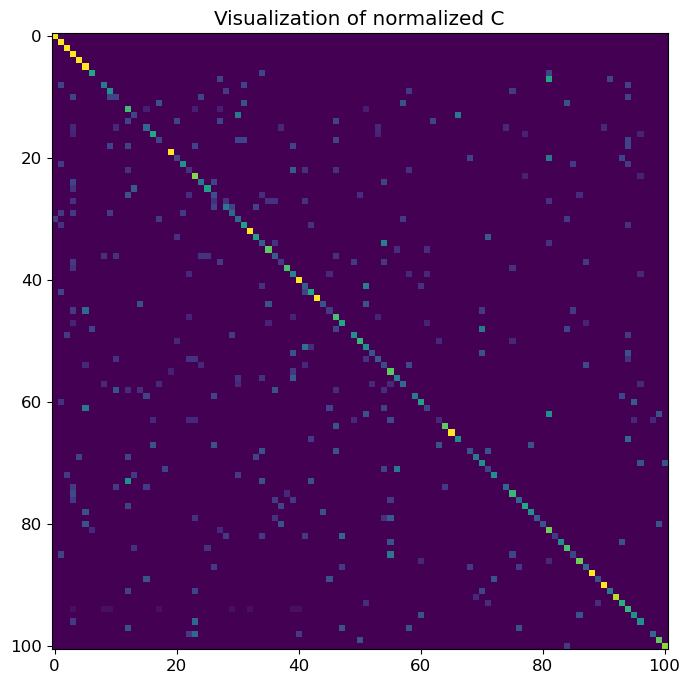

In [119]:
plt.figure(figsize=(10, 8)) 
plt.imshow(C_normed)
plt.title('Visualization of normalized C')
plt.show()

In [120]:

C_normed=C_normed*100

for i in range(C_normed.shape[0]):
    C_ac=C_normed[i,i]
    print(categories[i] + ': ', C_ac, '%')
    row_n=np.where(C_normed[i,:] !=0)
    row_i=np.delete(row_n[0], np.where(row_n[0]==i))
    if (len(row_i)>0):
        print('        Confused with:')
        for j in range (len(row_i)):
            print('                ', categories[row_i[j]], ': (', C_normed[i,row_i[j]],'% )')
        
            
        

        
    
    

Faces:  97.72727272727273 %
        Confused with:
                 Faces_easy : ( 2.272727272727273 % )
Faces_easy:  100.0 %
Leopards:  100.0 %
Motorbikes:  100.0 %
accordion:  100.0 %
airplanes:  100.0 %
anchor:  60.0 %
        Confused with:
                 dragonfly : ( 20.0 % )
                 scorpion : ( 20.0 % )
ant:  0.0 %
        Confused with:
                 crayfish : ( 20.0 % )
                 scorpion : ( 60.0 % )
                 tick : ( 20.0 % )
barrel:  40.0 %
        Confused with:
                 Faces_easy : ( 20.0 % )
                 dalmatian : ( 20.0 % )
                 watch : ( 20.0 % )
bass:  50.0 %
        Confused with:
                 crocodile : ( 16.666666666666664 % )
                 llama : ( 16.666666666666664 % )
                 revolver : ( 16.666666666666664 % )
beaver:  20.0 %
        Confused with:
                 Motorbikes : ( 20.0 % )
                 bass : ( 20.0 % )
                 cougar_body : ( 20.0 % )
                 watc

We find that feature extraction takes much longer time compared to the time taken for classification. We get best classification accuracy (100%) for categories: Faces_easy, Leopards, Motorbikes, accordion, airplanes, car_side, dollar_bill, ferry, garfield, minaret, stop_sign, and sunflower.  We get worst classification accuracy (0%) for categories: ant, binocular, brontosaurus, cannon, crayfish, headphone, llama, mayfly, octopus, platypus, and wild_cat. We observe some misclassifications which makes sense (as similar objects) for example: lobster with crab, sea_horse with flamingo, cougar_body with kangaroo. We also observe some misclassifications which makes no sense for example: butterfly with motorbikes, headphone with panda.

## (g-vii) Performance on the entire CalTech101 dataset without annotations: 
We repeat part (g-vi) for the entire CalTech101 dataset without annotations, i.e., similar to the approach you used in part (g-iii).


In [121]:
begin_time=time.time()
category_dir = sorted(glob.glob('101_ObjectCategories/*'))
categories=[]
for i in range(len(category_dir)):
    categories.append(category_dir[i][21:])

train_in=[]
test_in=[]
test_out=[]
train_out=[]

for i,categ in enumerate(categories):
    im_dir=sorted(glob.glob('101_ObjectCategories/' + categories[i] +'/*'))
    annot_dir=sorted(glob.glob('Annotations/' + categories[i] +'/*'))
    
    im_dir1,annot_dir1 = remove_missing_files(im_dir,annot_dir)
    im_dir2, annot_dir2=remove_empty(im_dir1,annot_dir1)
    
    N=len(im_dir2)
    tr_len=(np.floor(N*0.9)).astype(int)
    arr=np.zeros((N,62))
    label=[]
    lb=categories[i]
    for j,image_filename in enumerate(im_dir2):
        label.append(lb)
        I = imageio.imread(im_dir2[j])
        A3=np.ones((I.shape[0], I.shape[1]))
        #color features extraction
        f_color,fnames=extract_color_features(I,A3)
        #texture features extraction
        f_texture, f_names=extract_texture_features(I,A3)
        all_feature=[]
        all_feature=np.hstack((all_feature,f_color))
        all_feature=np.hstack((all_feature,f_texture))
        all_feature=np.array(all_feature)
        arr[j, :]=all_feature
    
    train=arr[0:tr_len, :]
    train_in.append(train)
    train_lb=label[0:tr_len]
    train_out.append(train_lb)
    test=arr[tr_len:, :]
    test_in.append(test)
    test_lb=label[tr_len:]
    test_out.append(test_lb)

X_train = np.concatenate(train_in, axis=0)
X_test = np.concatenate(test_in, axis=0)

y_train=np.concatenate(train_out, axis=0)
y_test=np.concatenate(test_out, axis=0)

total_time=time.time()-begin_time
print('Total time taken for feature extraction: ', total_time, 's')

Total time taken for feature extraction:  272.7758557796478 s


In [122]:

Xn_train,mx,mn=normalize_Xtrain(X_train)
Xn_test=normalize_Xtest(X_test,mx,mn)


begin_time2=time.time()
clf=svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)
y_test_hat=clf.predict(Xn_test)

total_time2=time.time()-begin_time2
print('Total time taken for classification: ', total_time2, 's')



Total time taken for classification:  2.6539461612701416 s


In [123]:
C=sklearn.metrics.confusion_matrix(y_test,y_test_hat,labels=categories)
acc=np.diag(C).sum().astype(float)/C.sum()


print('Confusion matrix:')
print(C)

Confusion matrix:
[[39  4  0 ...  0  0  0]
 [ 4 39  0 ...  0  0  0]
 [ 0  0 20 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  0  3]]


In [124]:
print('Classification accuracy: ', acc)

Classification accuracy:  0.407244785949506


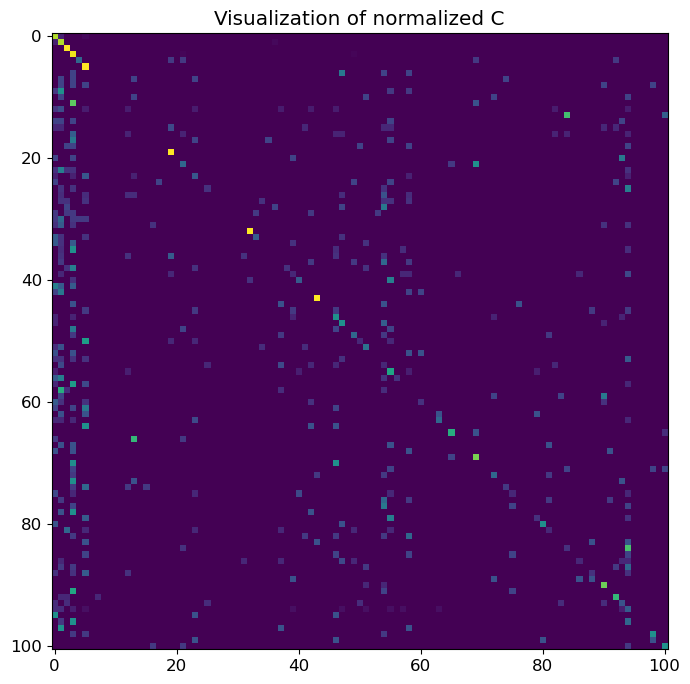

In [125]:
C_normed = normalize(C, axis=1, norm='l1')

plt.figure(figsize=(10, 8)) 
plt.imshow(C_normed)
plt.title('Visualization of normalized C')
plt.show()

In [126]:
C_normed=C_normed*100

for i in range(C_normed.shape[0]):
    C_ac=C_normed[i,i]
    print(categories[i] + ': ', C_ac, '%')
    row_n=np.where(C_normed[i,:] !=0)
    row_i=np.delete(row_n[0], np.where(row_n[0]==i))
    if (len(row_i)>0):
        print('        Confused with:')
        for j in range (len(row_i)):
            print('                ', categories[row_i[j]], ': (', C_normed[i,row_i[j]],'% )')
        

Faces:  88.63636363636364 %
        Confused with:
                 Faces_easy : ( 9.090909090909092 % )
                 airplanes : ( 2.272727272727273 % )
Faces_easy:  88.63636363636364 %
        Confused with:
                 Faces : ( 9.090909090909092 % )
                 elephant : ( 2.272727272727273 % )
Leopards:  100.0 %
Motorbikes:  97.5 %
        Confused with:
                 cellphone : ( 1.25 % )
                 hedgehog : ( 1.25 % )
accordion:  33.33333333333333 %
        Confused with:
                 car_side : ( 16.666666666666664 % )
                 cellphone : ( 16.666666666666664 % )
                 pagoda : ( 16.666666666666664 % )
                 trilobite : ( 16.666666666666664 % )
airplanes:  100.0 %
anchor:  0.0 %
        Confused with:
                 Motorbikes : ( 20.0 % )
                 hawksbill : ( 40.0 % )
                 kangaroo : ( 20.0 % )
                 llama : ( 20.0 % )
ant:  0.0 %
        Confused with:
                 Faces_easy 

                 Faces_easy : ( 11.11111111111111 % )
                 Leopards : ( 11.11111111111111 % )
                 ant : ( 11.11111111111111 % )
umbrella:  25.0 %
        Confused with:
                 Faces : ( 12.5 % )
                 Leopards : ( 12.5 % )
                 cougar_face : ( 12.5 % )
                 helicopter : ( 12.5 % )
                 snoopy : ( 12.5 % )
                 sunflower : ( 12.5 % )
watch:  29.166666666666668 %
        Confused with:
                 Faces : ( 12.5 % )
                 Faces_easy : ( 12.5 % )
                 Motorbikes : ( 8.333333333333332 % )
                 airplanes : ( 4.166666666666666 % )
                 ewer : ( 4.166666666666666 % )
                 hawksbill : ( 4.166666666666666 % )
                 ibis : ( 4.166666666666666 % )
                 ketch : ( 4.166666666666666 % )
                 laptop : ( 4.166666666666666 % )
                 menorah : ( 4.166666666666666 % )
                 umbrella : ( 8.3333

We find that feature extraction takes more time compared to the time taken for classification. Without annotations, we get best classification accuracy (100%) for categories: Leopards, airplanes, car_side, dollar_bill, and garfield. We get worst classification accuracy (0%) for categories: anchor, ant, barrel, bass, beaver, binocular, brain, brontosaurus, buddha and a lot of other categories. We can easily observe that without annotations, the classifier performs worse compared to part (g-vi)(with annotations). This is because there are less features without annotations compared to with annotations.There is no logical trend for misclassification and misclassifications make no sense. For example, the watch is misclassified as laptop, the lobster is misclassified as faces_easy.

## (h) Summary:
In this projec, we learned about image classification using feature extraction and classical machine learning. For classical machine learning, we perform feature extraction manually with some classical methods. For image classification, it is necessary to extract as much relevant features from the images for getting better accuracy from a classifier. The importance of feature category changes with respect to the images in a dataset which need to be classified. Without annotations, number of extracted feactures for a image is much less compared to with annotations which results in poor classification accuracy. Normalization of features are very important to get better classification accuracy.

In this project, we use a support vector machine (SVM) classifier for image classification. SVM classifier works very well with two classes. With large number of classes, the accuracy of SVM classifier decreases significantly (63% for 101 classes) which is as expected. This is because SVM classifier is a very simple classifier and we use linear kernel. We observe some misclassifications which makes no sense for example: butterfly with motorbikes, headphone with panda. We also observe that without annotations the classifier performs worst (40% for 101 classes). 

In my view, the biggest issue affecting the performance is proper choice of extracted features and the selection of classifier. More relevant features and more sophisticated classifier may result in better classification accurary. By applying deep learning approach for automatically extracting features and using  more sophisticated deep learning model as classifier may improved the classification accuracy for large number of classes in a dataset.
